- RandomForest, XGBoost는 다중공선성 제거가 필요없지만    
  Lasso는 선형 회귀 기반이라 다중공선성 제거를 해야 함 (L1이라 정규화는 하겠지만)   
- 로그 변환이 필요함 - 타겟 피쳐 + 왜도 > 1 피쳐(데이터 탐색에서 확인)

In [2]:
# 한글, 음수 시각화 설정

#시각화 패키지
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd 
import numpy as np
import re 

from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
# from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df = pd.read_csv('../../data/prp_factory_glass_2016.csv', index_col= 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8142 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 197 entries, LIFT.OUT.ROL.MTR.M.SPD to R.Vac
dtypes: float64(197)
memory usage: 12.3+ MB


,LIFT.OUT.ROL.MTR.M.SPD,LEHR.DRV.MTR.M.SPD,DRV.MTR.M.SPD,X,DCS.Offset.RPM.M,DAMP.POSITION.BAY.CTRL,DB.N2.SCREEN.FLOW.LEFT,DB.N2.SCREEN.FLOW.RIGHT,N2.TO.EA1313A,ROOF.HEATING.Zone,...,STD.U.L,STD.U.R,STD.L.L,STD.L.R,STD.GLS.L,STD.GLS.R,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.742443,-1.699444,-1.683797,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.040366,...,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,0.025,0.063,0.108,0.041
2016-01-01 08,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.028982,...,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,0.000,0.022,0.133,0.000
2016-01-01 09,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.065345,...,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,0.016,0.063,0.000,0.000
2016-01-01 10,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.084378,...,0.549254,2.047995,2.399854,2.810619,2.876398,2.914596,0.000,0.103,0.000,0.000
2016-01-01 11,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.024016,...,0.610913,2.101178,2.379341,2.797094,2.858177,2.873929,0.000,0.000,0.000,0.000


> ### 왼쪽 공정만 추출

- 왼쪽 공정 중 L / l이 포함된 경우 lower과 겹칠 가능성이 있어 제외 안함

In [5]:
cols = df.columns

# 1. LEFT 키워드 , RIGHT 키워드
left_keyword_cols = [
    col for col in cols
    if re.search(r'(LEFT|U\.L|L\.L|u\.l|l\.l|L\.RD|L\.Vac)', col, flags=re.IGNORECASE)
]

right_keyword_cols = [
    col for col in cols
    if re.search(r'(RIGHT|U\.R|L\.R|u\.r|l\.r|R\.RD|R\.Vac|\.R\b)', col, flags=re.IGNORECASE)
]

# 2. 공통 공정 = LEFT도 아니고 RIGHT도 아닌 컬럼
common_cols = [col for col in cols if col not in left_keyword_cols and col not in right_keyword_cols]

# 데이터프레임 구성
left_feature_df = df[left_keyword_cols].copy()
right_feature_df = df[right_keyword_cols].copy()
common_feature_df = df[common_cols].copy()

# 결과 확인
print("✅ 왼쪽 공정 수:", len(left_feature_df.columns))
print("✅ 오른쪽 공정 수:", len(right_feature_df.columns))
print("✅ 공통 공정 수:", len(common_feature_df.columns))


✅ 왼쪽 공정 수: 30
✅ 오른쪽 공정 수: 42
✅ 공통 공정 수: 126


In [6]:
# 왼쪽 feature_df 구성
left_df = pd.concat([common_feature_df, left_feature_df], axis=1)
print("✅ 최종 왼쪽 feature_df 컬럼 수:", left_df.shape[1])


✅ 최종 왼쪽 feature_df 컬럼 수: 156


> ### 피쳐 - 타겟 분리

In [7]:
left_df.head()

,LIFT.OUT.ROL.MTR.M.SPD,LEHR.DRV.MTR.M.SPD,DRV.MTR.M.SPD,X,DCS.Offset.RPM.M,DAMP.POSITION.BAY.CTRL,N2.TO.EA1313A,ROOF.HEATING.Zone,ATM.FLOW.SECT.N2.H2,ATM.FLOW.SECT.N2,...,S.AB.AB.U.L,S.AB.AB.L.L,S.AB.C.U.L,S.AB.C.L.L,S.C.C.U.L,S.C.C.L.L,STD.U.L,STD.L.L,L.RD,L.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.742443,-1.699444,-1.683797,-0.755452,-1.947792,-1.251006,-0.218748,0.040366,-1.812108,0.172787,...,0.047915,-0.172226,0.146778,1.772574,1.405119,0.785430,0.523950,2.248106,0.025,0.063
2016-01-01 08,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.028982,-1.792364,0.252142,...,0.025103,-0.189845,0.161917,1.871182,1.433834,0.749426,0.566521,2.364418,0.000,0.022
2016-01-01 09,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.065345,-1.815574,0.283121,...,0.009143,-0.196662,0.153177,1.826206,1.446866,0.805319,0.545936,2.397034,0.016,0.063
2016-01-01 10,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.084378,-1.846923,0.157744,...,-0.018994,-0.201060,0.173210,1.853880,1.434837,0.751488,0.549254,2.399854,0.000,0.103
2016-01-01 11,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.024016,-1.855973,0.180923,...,-0.037802,-0.204591,0.163199,1.792980,1.447733,0.816928,0.610913,2.379341,0.000,0.000


In [8]:
feature_df = left_df.iloc[:, :-2]
feature_df.head()

target_df = left_df[['L.RD']] # 다른 변수들의 선형 결합이므로
target_df.head()

,L.RD
dat...date.name.,
2016-01-01 07,0.025
2016-01-01 08,0.000
2016-01-01 09,0.016
2016-01-01 10,0.000
2016-01-01 11,0.000


In [9]:
# 1. NaN이 포함된 열만 추출
nan_cols = feature_df.columns[feature_df.isnull().any()]

# 2. 각 열별 NaN 개수 출력
nan_summary = feature_df[nan_cols].isnull().sum()

print("🔍 로그 변환 전 결측치 열:")
print(nan_summary.sort_values(ascending=False))

🔍 로그 변환 전 결측치 열:
Series([], dtype: float64)


> ### 로그 변환

- 피쳐 데이터 중 왜도 > 1
- 타겟 데이터

In [10]:
skewed_feats = feature_df.apply(skew)
skewed_cols = skewed_feats[abs(skewed_feats) > 1.0].index

In [11]:
feature_log_df = feature_df.copy()

In [12]:
# 사인 함수 + 로그 변환
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

# 적용
feature_df[skewed_cols] = feature_df[skewed_cols].apply(signed_log_transform)
target_df = target_df.apply(np.log1p)

In [13]:
# 변환 후 NaN 발생한 컬럼 확인
nan_cols = feature_log_df.columns[feature_log_df.isnull().any()]
print("🚨 변환 후 NaN 발생한 열:")
print(nan_cols)
print(len(nan_cols))

🚨 변환 후 NaN 발생한 열:
Index([], dtype='object')
0


In [14]:
target_df.head()

,L.RD
dat...date.name.,
2016-01-01 07,0.024693
2016-01-01 08,0.000000
2016-01-01 09,0.015873
2016-01-01 10,0.000000
2016-01-01 11,0.000000


> ### train-test 분리

In [15]:
X_train, X_test, y_train , y_test = train_test_split(feature_df, target_df, test_size=0.2, random_state= 42, )

print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (6513, 154)
X_test :  (1629, 154)
y_train :  (6513, 1)
y_test :  (1629, 1)


> ### RandomForest 적용

In [41]:
rf_clf_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators= 300, max_depth= 9, min_samples_split= 3, min_samples_leaf = 3, max_features= 'sqrt', random_state= 42)
)
# max_depth : 작을수록 과적합 방지 > 5~7이 일반적으로 안정적
# min_samples_split : 값을 높일수록 과적합 방지 5 > 9
# min_samples_leaf : 리프 노드에 필요한 최소 샘플 수 > 일반적으로 2~5
# max_features : 피쳐 중 일부만 학습

# 300 > 500
# 9 > 5 > 3
# min_saples_leaf 3 > 5

rf_clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=9, max_features='sqrt',
                                       min_samples_leaf=3, min_samples_split=3,
                                       n_estimators=300, random_state=42))])

In [43]:
rf_clf_pipe.score(X_train, y_train) # 77.68%
rf_clf_pipe.score(X_test, y_test) # 56.09%

0.5608842358046898

In [44]:
y_pred = rf_clf_pipe.predict(X_test)

print("✅ RMSE:", mean_squared_error(y_test, y_pred, squared=False)) # 예측값 - 실제값 사이 평균 오차 
print("✅ R² score:", r2_score(y_test, y_pred)) # 전체 변동성 중 설명 가능한 변동성

# 피처 중요도 추출
importances = rf_clf_pipe.named_steps['randomforestregressor'].feature_importances_
selected_features = pd.Series(importances, index=X_train.columns)
selected_features = selected_features.sort_values(ascending=False)

print("🎯 중요도가 높은 공정 피처 Top 15:")
print(selected_features.head(15))

✅ RMSE: 0.02517585311591289
✅ R² score: 0.5608842358046898
🎯 중요도가 높은 공정 피처 Top 15:
SPOUT.LEFT.BOTTOM                0.047260
N2.TO.EA1315B                    0.026447
ROOF.HT.BAY.TOTAL.PWR.1CLBAY9    0.020869
S.C.C.L.L                        0.020832
l.n.glass                        0.019236
S.C.C.U.L                        0.017575
TMP.GLASS.CENTER.EXIT            0.016680
TMP.GLASS.ZONE.AB.E1             0.015314
TMP.GLASS.ZONE.AB.L5             0.015070
ATM.FLOW.SECT.N2.PV              0.014832
r.n.glass                        0.014605
TMP.GLASS.ZONE.AB.L2             0.014303
DB.HEAT.BTM.LEFT.TMP             0.013167
TMP.GLASS.ZONE.AB.L1             0.012861
re.btm.up.dn                     0.012115
dtype: float64


> ### 주요 공정 분포 확인

In [45]:
main_features = selected_features.keys()[:15]
print(main_features)

Index(['SPOUT.LEFT.BOTTOM', 'N2.TO.EA1315B', 'ROOF.HT.BAY.TOTAL.PWR.1CLBAY9',
       'S.C.C.L.L', 'l.n.glass', 'S.C.C.U.L', 'TMP.GLASS.CENTER.EXIT',
       'TMP.GLASS.ZONE.AB.E1', 'TMP.GLASS.ZONE.AB.L5', 'ATM.FLOW.SECT.N2.PV',
       'r.n.glass', 'TMP.GLASS.ZONE.AB.L2', 'DB.HEAT.BTM.LEFT.TMP',
       'TMP.GLASS.ZONE.AB.L1', 're.btm.up.dn'],
      dtype='object')


In [46]:
feature_df[main_features].describe()

,SPOUT.LEFT.BOTTOM,N2.TO.EA1315B,ROOF.HT.BAY.TOTAL.PWR.1CLBAY9,S.C.C.L.L,l.n.glass,S.C.C.U.L,TMP.GLASS.CENTER.EXIT,TMP.GLASS.ZONE.AB.E1,TMP.GLASS.ZONE.AB.L5,ATM.FLOW.SECT.N2.PV,r.n.glass,TMP.GLASS.ZONE.AB.L2,DB.HEAT.BTM.LEFT.TMP,TMP.GLASS.ZONE.AB.L1,re.btm.up.dn
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,-0.000115,0.108383,-0.000314,-0.000224,-0.103507,0.000181,-0.092853,-0.067597,-0.018044,-0.107765,-0.064426,-0.014070,-0.001339,-0.017860,0.001281
std,1.000489,0.583329,1.000414,0.518821,0.405634,0.739220,0.474634,0.529896,0.435668,0.526129,0.538138,0.461900,0.710844,0.437592,0.999909
min,-2.297424,-1.345180,-3.869119,-1.645259,-0.558408,-1.608711,-1.184584,-1.285005,-2.087212,-0.625294,-1.492061,-2.084387,-2.482250,-2.151369,-2.099379
25%,-0.534767,0.342998,-0.529187,-0.390381,-0.229976,-0.635590,-0.290846,-0.370975,-0.316064,-0.380294,-0.377688,-0.354084,-0.289572,-0.330836,-0.710049
50%,-0.111170,0.365107,0.303517,0.087233,-0.206271,0.001196,-0.227095,-0.212038,-0.029811,-0.286660,-0.117158,-0.012662,0.109604,-0.035129,0.188042
75%,0.298863,0.385949,0.315713,0.325840,-0.188531,0.559079,-0.143696,0.059900,0.249740,-0.182067,0.031985,0.299432,0.471441,0.261209,0.499149
max,3.104699,0.623206,3.101587,3.684065,1.788174,3.412793,2.203441,2.004505,2.948110,1.421196,1.606474,2.999042,1.850127,2.978289,3.619941


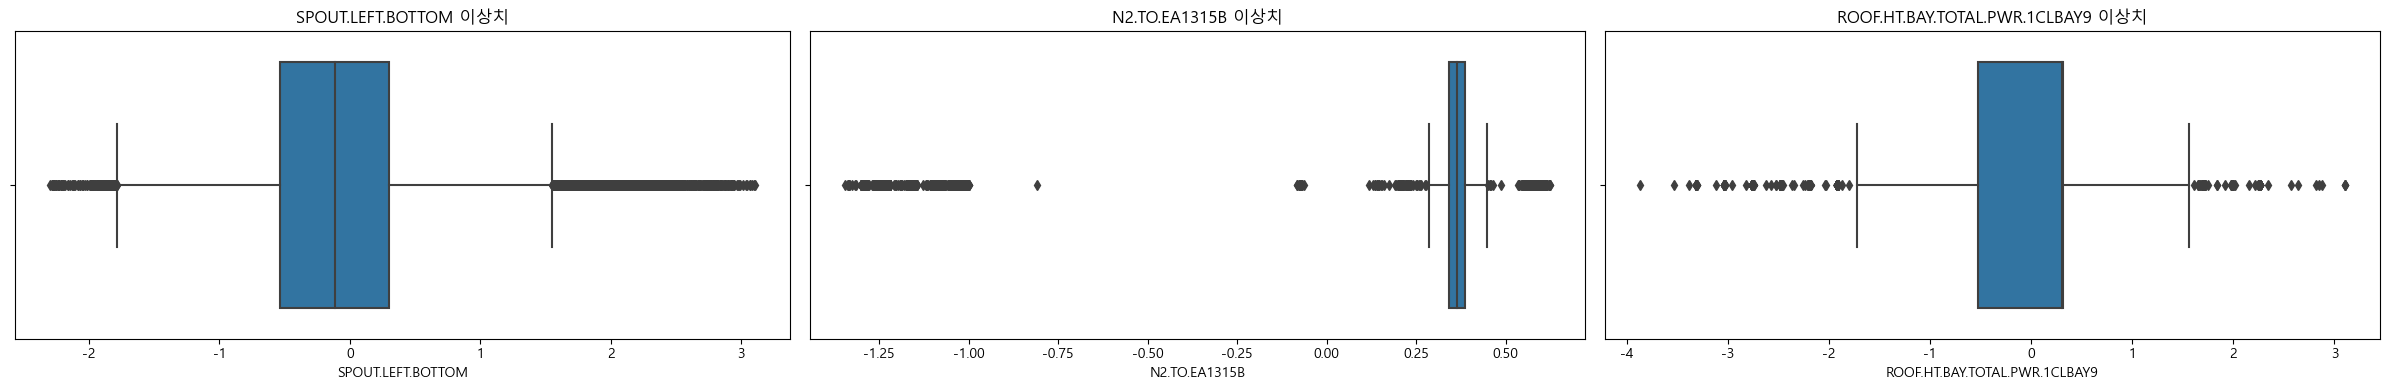

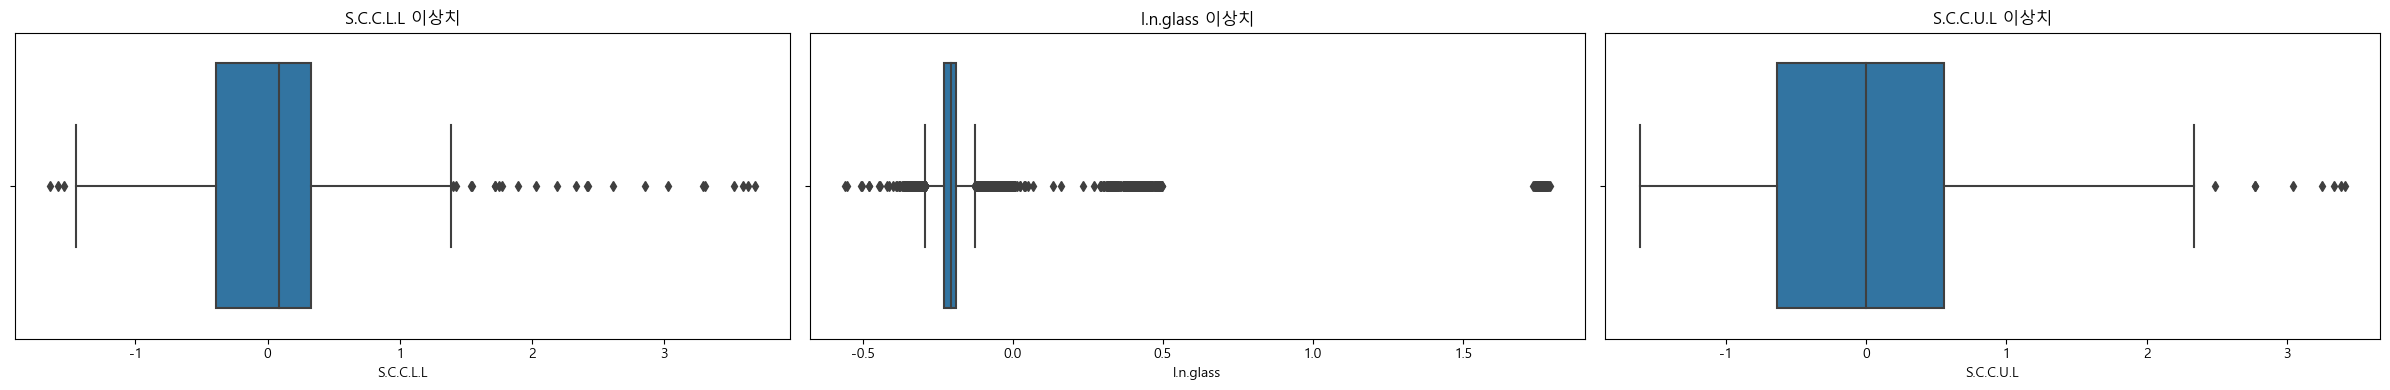

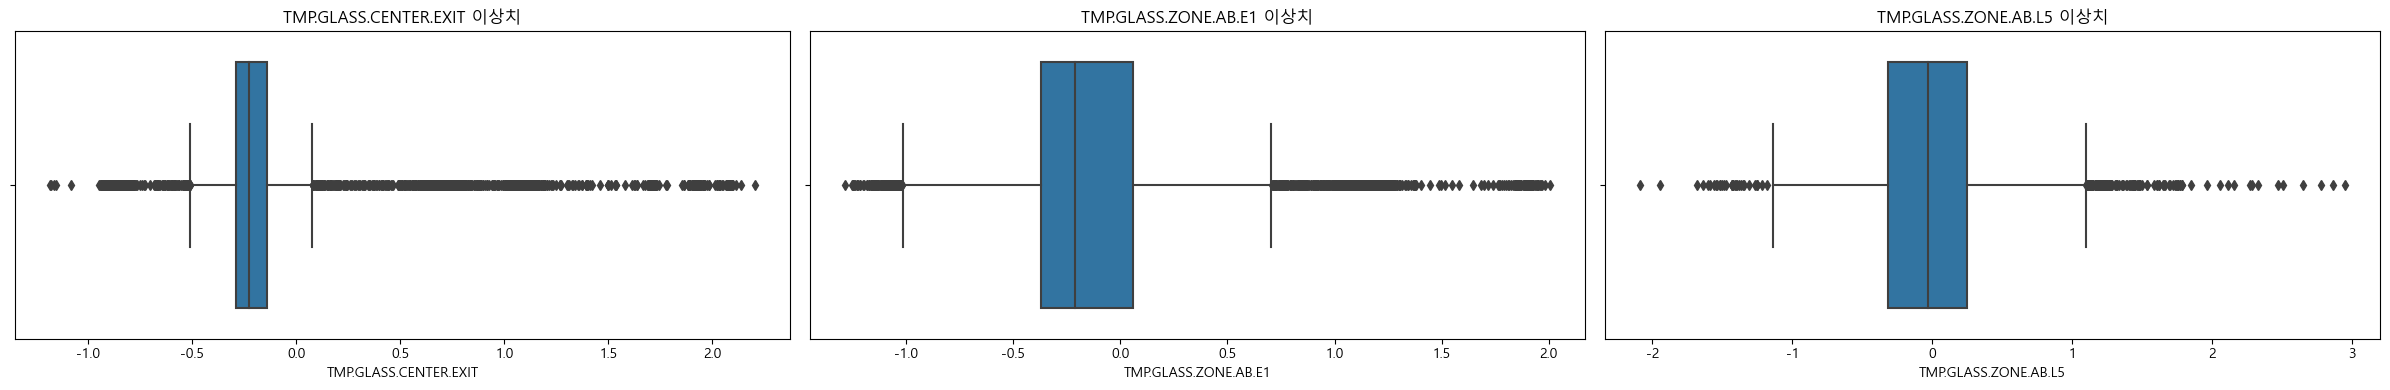

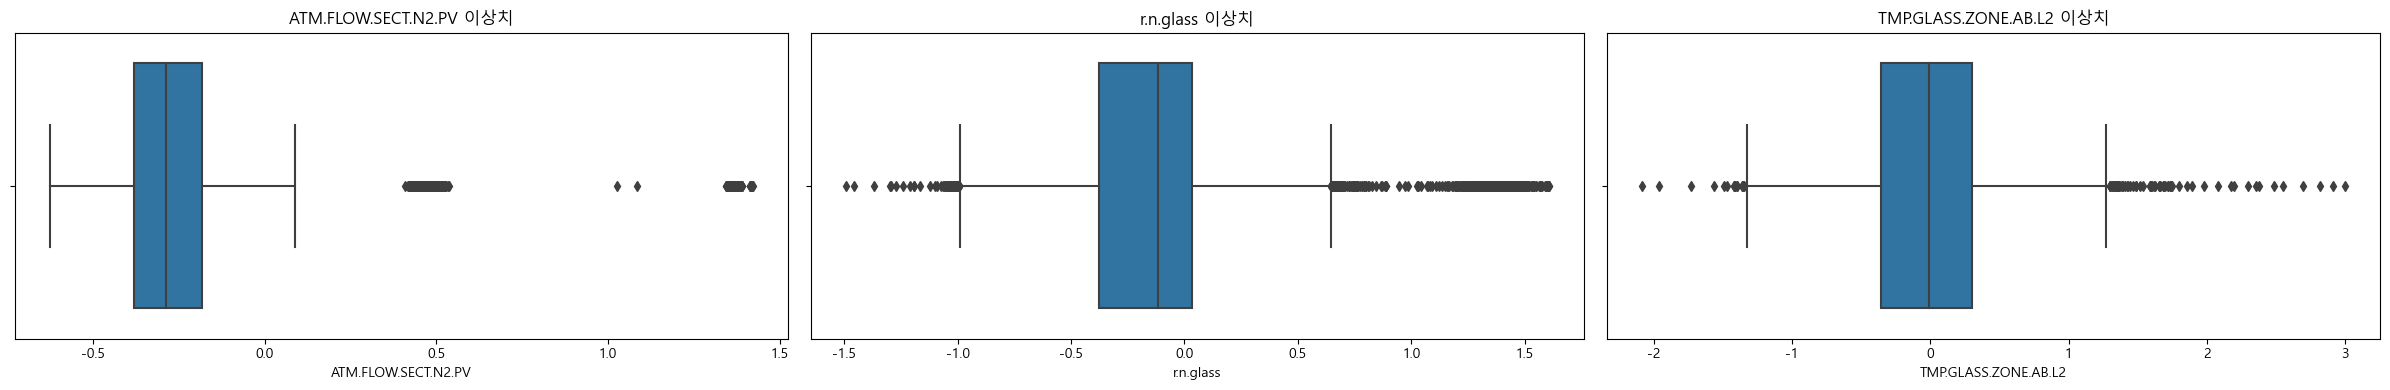

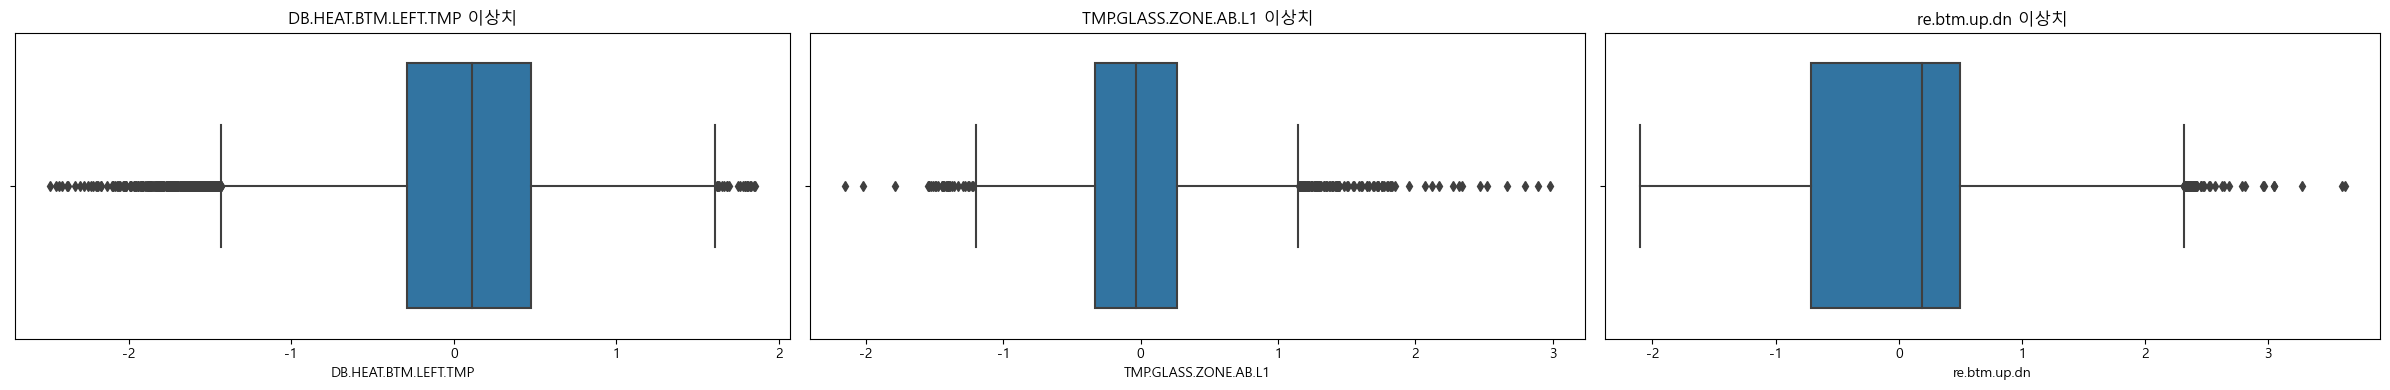

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

n_cols = 3  # 한 행에 3개씩
n_rows = math.ceil(len(main_features) / n_cols)

for i in range(0, len(main_features), n_cols):
    features_chunk = main_features[i:i + n_cols]
    fig, axes = plt.subplots(1, len(features_chunk), figsize=(8 * len(features_chunk), 4))

    if len(features_chunk) == 1:
        axes = [axes]  # 한 개일 경우도 리스트로 변환

    for ax, col in zip(axes, features_chunk):
        sns.boxplot(data=feature_df, x=col, ax=ax)
        ax.set_title(f"{col} 이상치")

    plt.tight_layout()
    plt.show()

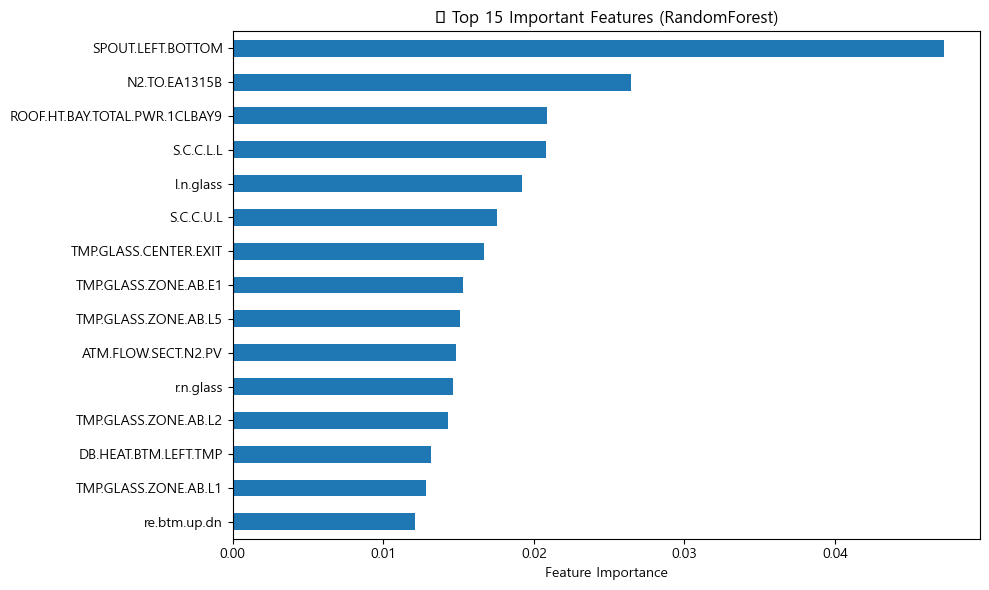

In [48]:
# 시각화: 상위 15개 피처 중요도
plt.figure(figsize=(10, 6))
selected_features.head(15).sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("🎯 Top 15 Important Features (RandomForest)")
plt.tight_layout()
plt.show()

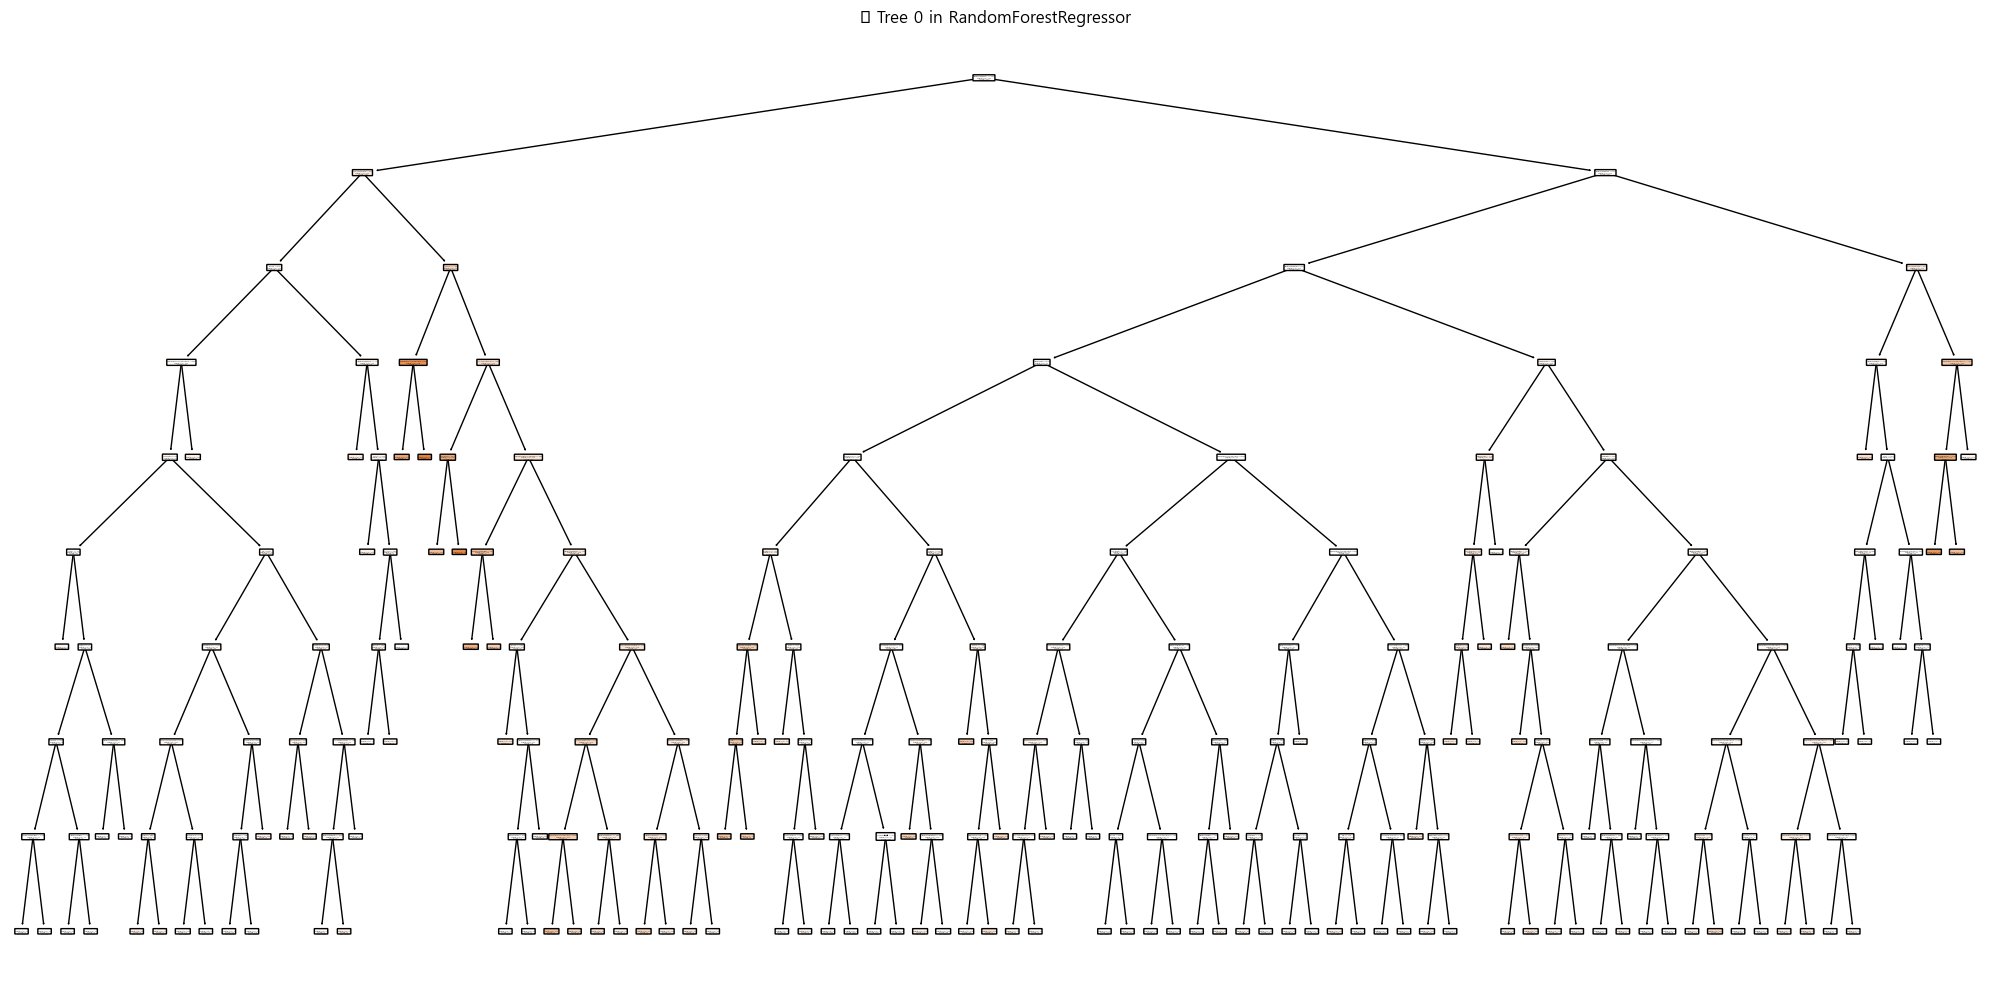

In [49]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# RandomForestRegressor 모델 꺼내기
rf_model = rf_clf_pipe.named_steps['randomforestregressor']

# 첫 번째 결정 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], feature_names=X_train.columns, filled=True, rounded=True)
plt.title("📊 Tree 0 in RandomForestRegressor")
plt.tight_layout()
plt.show()